# The Curse of Conditoning on Colliders

Recently, I read an [interesting article](https://www.theatlantic.com/business/archive/2012/05/when-correlation-is-not-causation-but-something-much-more-screwy/256918/?utm_source=fbb) about a phenomenon in observed data called "conditioning on a collider." Essentially, 

> *If a case being observed is a function of two variables then this will induce an artifactual negative correlation  between the variables. This is true even if in the broader population there is no correlation (or even a mild positive correlation) between the variables.*

I wanted to see if I could replicate the author's findings and also investigate some more complicated cases. This is what I'll do here.

## A Simple Case

Let's first consider the simple case presented in the article: We have a population with two traits, both of which are standard-normally distributed ($\mu = 0, \sigma^{2}=1$). Let's say we're looking at stand-up comics, and assume their success depends only on (1) their marketing skill ($m$) and (2) their humor ($h$). We'll define a *success function* which returns either $1$ (success) or $0$ (failure) depending on $m, h$. To summarize, 
$$m \sim N(0, 1)$$
$$h \sim N(0, 1)$$
$$s(m, h) = \begin{cases} 1 &\text{if } m + h \geq 2 \\ 0 &\text{otherwise} \end{cases}$$

Then while there's no actual correlation between humor and marketing skill for all comics, we'll observe a negative correlation between $m, h$ for the successful comics. 

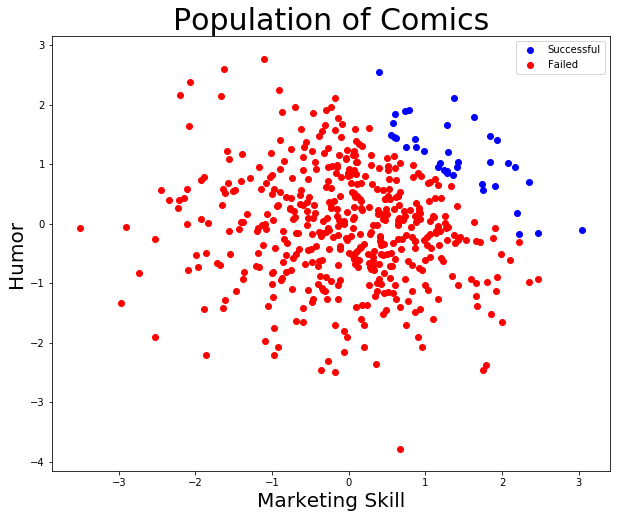

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from collections import OrderedDict
%matplotlib inline
np.set_printoptions(3)

fig = plt.figure(figsize=[10, 8])
ax = plt.subplot()
selection_regime = lambda x, y: (x + y) > 2
observed_vals = []
for _ in range(500): 
    x_val, y_val = np.random.normal(0, 1), np.random.normal(0, 1)
    if (selection_regime(x_val, y_val)): 
        observed_vals.append([x_val, y_val])
        ax.scatter(x_val, y_val, color='blue', label='Successful')
    else:
        ax.scatter(x_val, y_val, color='red', label='Failed')
ax.set_xlabel('Marketing Skill', fontsize=20)
ax.set_ylabel('Humor', fontsize=20)
ax.set_title('Population of Comics', fontsize=30)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize='10')

Evidenlty, there's no correlation between marketing skill and humor. But if we only consider the successful comics, we can observe an artifical negative correlation. Making a conservative assumption, let's use the Spearman correlation coefficient, which doesn't assume any underlying distribution of the data. Even then, there's a solid negative correlation of $r = -0.687$ and $p < 10^{-5}$.

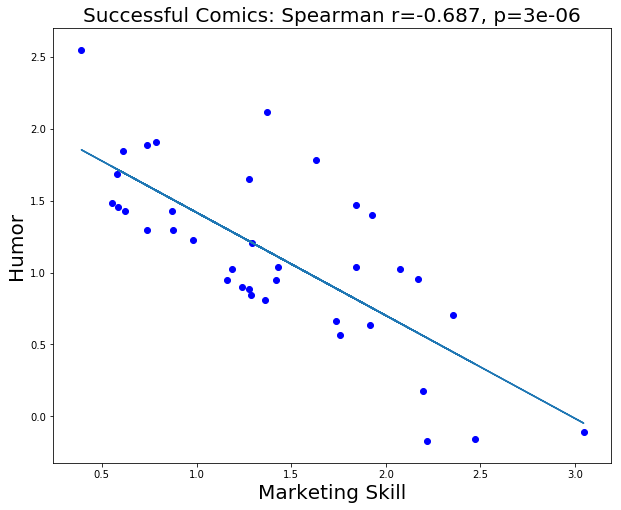

In [8]:
fig = plt.figure(figsize=[10, 8])

ax2 = plt.subplot()
observed_x_vals = [point[0] for point in observed_vals]
observed_y_vals = [point[1] for point in observed_vals]
for point in observed_vals: 
    ax2.scatter(point[0], point[1], color='blue')
best_fit_1d = np.polyfit(observed_x_vals, observed_y_vals, deg=1)
best_fit_func = lambda x: best_fit_1d[1] + (x*best_fit_1d[0])
ax2.plot(observed_x_vals, [best_fit_func(x) for x in observed_x_vals])

import scipy.stats
artificial_corr = scipy.stats.spearmanr(observed_x_vals, observed_y_vals)

ax2.set_xlabel('Marketing Skill', fontsize=20)
ax2.set_ylabel('Humor', fontsize=20)
ax2.set_title('Successful Comics: Spearman r={}, p={}'.format(round(artificial_corr[0], 3), round(artificial_corr[1], 6)), fontsize=20)
plt.show()

So, when does this happen? Alarmingly often, according the the author. (Emphasis mine)

> Conditioning on a collider can occur any time that there is an underlying selection regime that involves either variables in the dataset or correlates of variables in the dataset. **This is almost inevitable if you have built a composite dataset out of multiple constituent datasets.** That is, a case appears in the sample if it meets one or more sampling criteria. This is actually a fairly common sample design, usually premised on the idea of not wanting to "miss anything" and/or wanting to increase the sample size. 

## More Complex Selection Regimes

In the previous example, the selection regime I used was fairly simple - the comic succeeded if $$m + h \geq 2$. In real life, the determinants of success (what I'll refer to as a **selection regime**) tend to be functions of many more variables, and far more complex than a simple linear function.